In [614]:
import torch
import torchvision 
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A

from PIL import Image
from pathlib import Path

from src.data import FashionDataset

In [57]:
data_folder = Path("input") 

train_folder = data_folder / "train"
test_folder = data_folder / "test"

In [56]:
train_description = pd.read_csv(data_folder / "train.csv")

In [63]:
with open(data_folder / "label_descriptions.json") as f:
    label_description = json.load(f)


In [68]:
label_description["categories"][42]

{'id': 42, 'name': 'rivet', 'supercategory': 'decorations', 'level': 2}

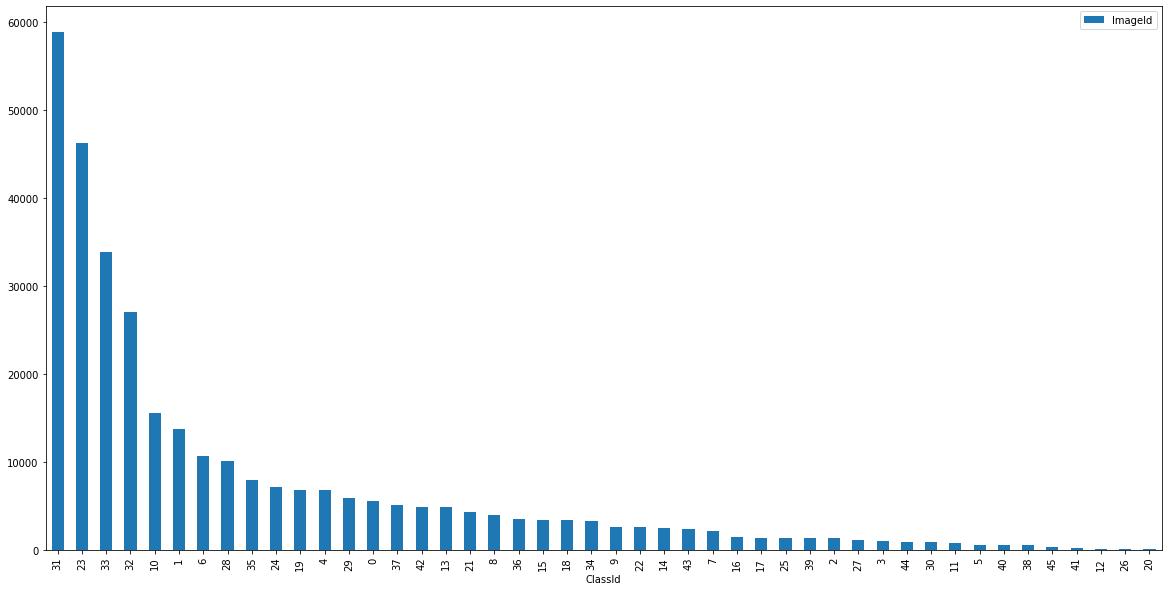

In [119]:
# train_description[["ImageId", "ClassId"]] \
# .to_csv("freq.csv")

train_description[train_description.ClassId.apply(lambda v: v in list(map(str, range(47))))][["ImageId", "ClassId"]]\
.groupby("ClassId") \
.count() \
.sort_values("ImageId", ascending=False) \
.plot.bar(figsize=(20, 10)) 
plt.savefig("freq.png", bbox_inches="tight")
# .sort_values("ImageId", ascending=False).plot()

In [47]:
res = train_description.groupby(["ImageId", "ClassId"]).filter(lambda g: g.shape[0] == 58)

In [120]:
# res

In [121]:
# Image.open(train_folder / res.ImageId.iloc[0])

In [127]:
"5_12_23".split("_")[0]

'5'

Available classes 

In [135]:
np.sort(train_description.ClassId.apply(lambda x: x.split("_")[0]).unique().astype(int))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

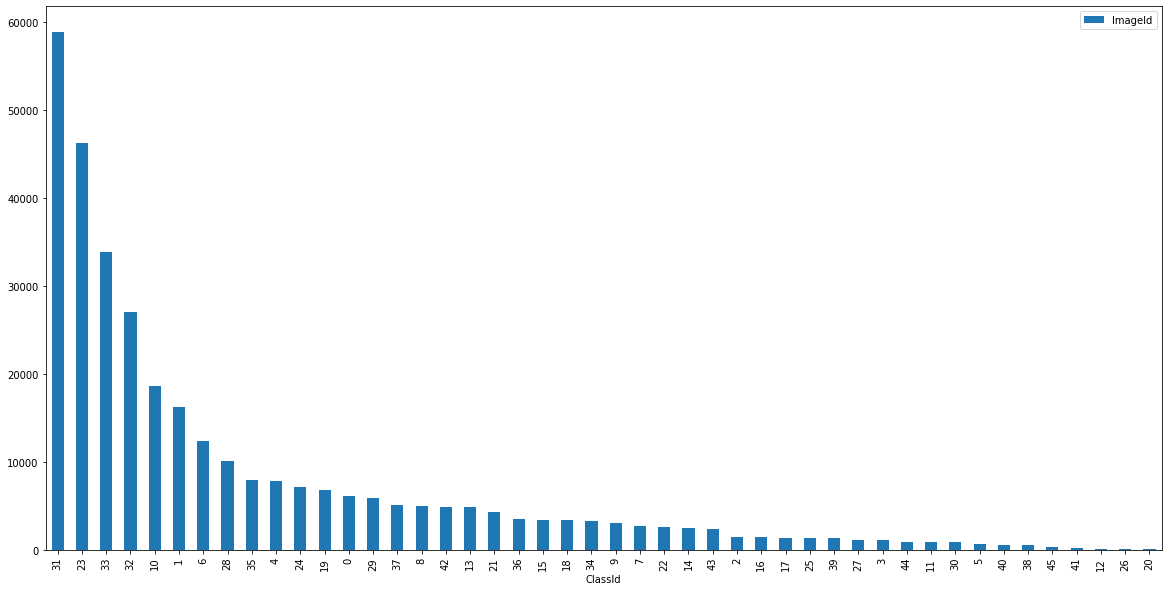

In [139]:
train_description_cleaned = train_description.copy(deep=True)
train_description_cleaned.ClassId = train_description_cleaned.ClassId.apply(lambda x: x.split("_")[0])

train_description_cleaned[["ImageId", "ClassId"]]\
.groupby("ClassId") \
.count() \
.sort_values("ImageId", ascending=False) \
.plot.bar(figsize=(20, 10)) 
plt.savefig("all-freq.png", bbox_inches="tight")

In [206]:
description.ClassId.min()

0

In [196]:

description = train_description.copy(deep=True)
description.ClassId = description.ClassId.apply(lambda x: int(x.split("_")[0]))
description = description.drop(columns=["Width", "Height"])
# description = description.set_index(["ImageId", "ClassId"])


In [209]:
description

,ImageId,EncodedPixels,ClassId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,32
...,...,...,...
331208,fffe20b555b98c3c1f26c8dfff275cbc.jpg,2712731 8 2715725 23 2718719 39 2721713 55 272...,28
331209,ffffbf7014a9e408bfbb81a75bc70638.jpg,71179 1 71678 3 72178 4 72678 4 73178 5 73679 ...,33
331210,ffffbf7014a9e408bfbb81a75bc70638.jpg,116648 5 117148 16 117648 22 118148 26 118647 ...,31
331211,ffffbf7014a9e408bfbb81a75bc70638.jpg,67711 1 68210 1 68709 2 69204 2 69208 3 69705 ...,31


In [443]:
from sklearn.model_selection import train_test_split

filenames = description.ImageId.unique()

train_fn, test_fn = train_test_split(filenames, test_size=0.2)
train_fn, val_fn = train_test_split(train_fn, test_size=0.1)

In [453]:
train_df = description[description.ImageId.isin(train_fn)]
test_df = description[description.ImageId.isin(test_fn)]
val_df = description[description.ImageId.isin(val_fn)]

In [454]:
train_df.to_csv("train-split.csv")
test_df.to_csv("test-split.csv")
val_df.to_csv("val-split.csv")

## Dataloader

In [416]:
%%time
name, origin, mask = FashionDataset("train", description, train_folder)[8]

CPU times: user 2.51 s, sys: 1.31 s, total: 3.82 s
Wall time: 3.87 s


In [572]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]


def denormalize(img_tensor):
    img_tensor = img_tensor.clone()
    for t, m, s in zip(img_tensor, MEAN, STD):
        t.mul_(s).add_(m)
    return img_tensor


def image_to_std_tensor(image, **params):
    image = torchvision.transforms.functional.to_tensor(image)
    image = torchvision.transforms.functional.normalize(image, MEAN, STD)
    return image


def mask_to_tensor(mask, **params):
    mask = np.transpose(mask,(2,0,1))
    return torch.tensor(mask).float()

custom_to_std_tensor = A.Lambda(image=image_to_std_tensor, mask=mask_to_tensor)

batch_size = 4
num_workers = 10

train_transforms = A.Compose([
    A.Resize(512, 512),
    A.Flip(),
    A.RandomRotate90(),
    

    A.RandomBrightness(),
    A.RandomContrast(),
    
    custom_to_std_tensor
])


datasets = {}

datasets["train"] = FashionDataset(
    "train",
    train_df,
    train_folder,
    train_transforms
)

datasets["test"] = FashionDataset(
    "train",
    test_df,
    train_folder,
    A.Compose([
        A.Resize(512, 512),
        custom_to_std_tensor
    ])
)

datasets["val"] = FashionDataset(
    "val",
    val_df,
    train_folder,
    A.Compose([
        A.Resize(512, 512),
        custom_to_std_tensor
    ])
)


dataloaders = {x: torch.utils.data.DataLoader(
    datasets[x], 
    batch_size=batch_size,
    num_workers=0,
#     shuffle=True
) for x in ["train", "test", "val"]}

In [573]:
%%time

names, origins, masks  = next(iter(dataloaders["test"]))

CPU times: user 5.05 s, sys: 1.49 s, total: 6.54 s
Wall time: 5.88 s


In [577]:
def draw(origin, masks):
    blends = {}
    for i, mask in enumerate(masks):
        if mask.bool().any():
            blends[label_description["categories"][i]["name"]] = blend(denormalize(origin), MaskInfo(mask, g=1.0))

    plt.figure(figsize=(20, 40))
    for i, (name, img) in enumerate(blends.items()):
        plt.subplot(10, 5, i+1)
        plt.title(name)
        plt.imshow(img)

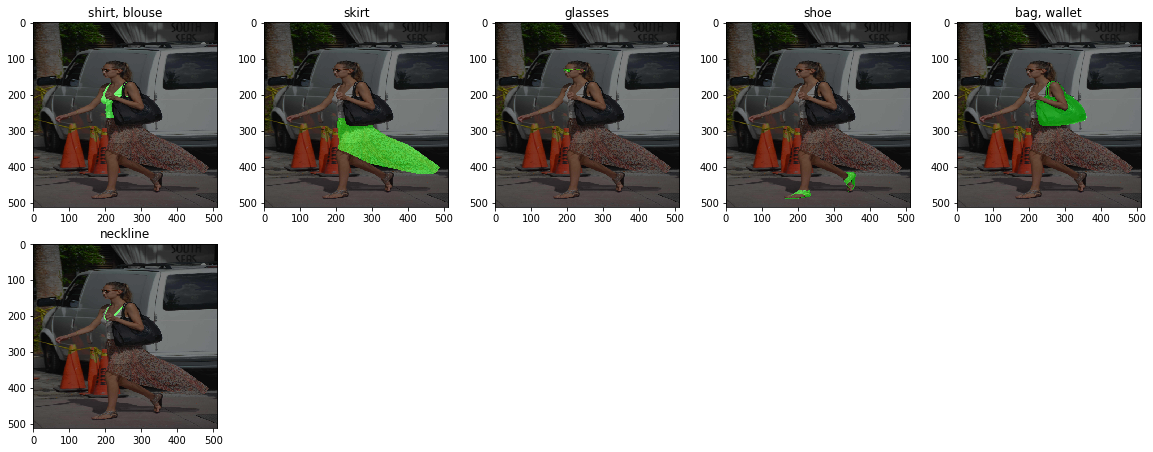

In [578]:
draw(origins[3], masks[3])

In [523]:
class MaskInfo:
    def __init__(self, mask, r=0.0, b=0.0, g=0.0):
        self.value = mask
        self.r = r
        self.g = g
        self.b = b
        

def blend(origin, *masks, alpha=0.5):
    img = torchvision.transforms.functional.to_pil_image(origin)
    
    for mask in masks:
        if mask is not None and mask.value is not None and mask.value.sum() != 0.0:
            mask = torchvision.transforms.functional.to_pil_image(torch.cat([
                torch.stack([mask.value.float()]) * mask.r,
                torch.stack([mask.value.float()]) * mask.g,
                torch.stack([mask.value.float()]) * mask.b,
            ]))
            img = Image.blend(img, mask, alpha)
    
    return img

In [579]:
from scipy.ndimage import label

3


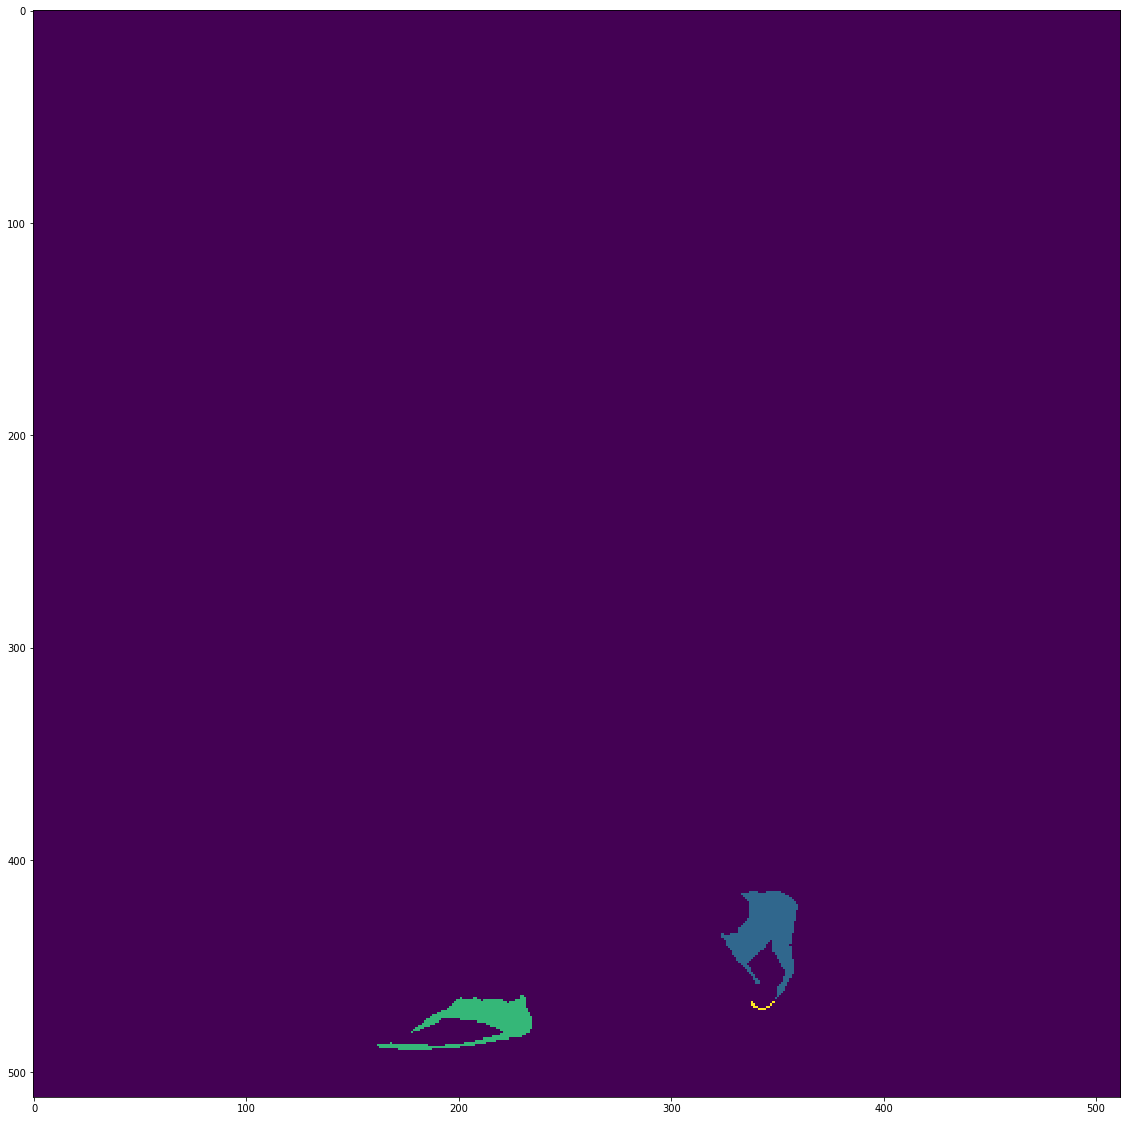

In [596]:
plt.figure(figsize=(20, 20))
res, n = label(masks[3][23], structure=np.ones((3, 3)))
plt.imshow(res)
print(n)

## Metric

In [598]:
import numpy as np
from functools import partial


def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    return tp, fp, fn


def calc_iou(y_true, y_prediction):
    y_true, y_prediction = map(partial(np.expand_dims, axis=0), (y_true, y_prediction))

    true_objects = len(np.unique(y_true))
    pred_objects = len(np.unique(y_prediction))

    # Compute intersection between all objects
    intersection = np.histogram2d(y_true.flatten(), y_prediction.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(y_true, bins=true_objects)[0]
    area_pred = np.histogram(y_prediction, bins=pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:, 1:]
    union = union[1:, 1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union
    return iou


def calc_score_per_class(y_true, y_prediction):
    iou = calc_iou(y_true, y_prediction)

    # Loop over IoU thresholds
    precisions = []
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        p = tp / (tp + fp + fn)
        precisions.append(p)
    return np.mean(precisions)

In [613]:
from scipy.ndimage.interpolation import shift
calc_score_per_class(res, shift(res, (1, 0), cval=0))

0.31